# ICC Cricket World Cup 2023 Analysis Report

## Introduction

This notebook provides a comprehensive analysis of the ICC Cricket World Cup 2023, covering various aspects of batting, bowling, fielding, and venue performance. The aim is to generate insights and statistics that contribute to a detailed report on the tournament.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    batting_df = pd.read_csv('batting_summary.csv')
    bowling_df = pd.read_csv('bowling_summary.csv')
    matches_df = pd.read_csv('match_schedule_results.csv')
    players_info_df = pd.read_csv('world_cup_players_info.csv')

    print("All datasets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure the CSV files are in the same directory.")
    exit()

# Display the column names and first few rows
print("Batting Summary Head:")
print(batting_df.head())

print("Bowling Summary Head:")
print(bowling_df.head())

print("Match Schedule Head:")
print(matches_df.head())

print("Players Info Head:")
print(players_info_df.head())


Error loading file: [Errno 2] No such file or directory: 'batting_summary.csv'. Make sure the CSV files are in the same directory.
Batting Summary Head:


NameError: name 'batting_df' is not defined

## 2. Data Preprocessing and Cleaning

This section handles all data cleaning, standardization, and preparation tasks to ensure the datasets are ready for analysis.

### 2.1 Column Name Standardization

In [ ]:
# Clean and standardize column names across all datasets
def clean_cols(df):
    """Clean column names: remove spaces, convert to lowercase, remove special characters"""
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)
    return df

batting_df = clean_cols(batting_df)
bowling_df = clean_cols(bowling_df)
matches_df = clean_cols(matches_df)
players_info_df = clean_cols(players_info_df)

### 2.2 Column Renaming for Consistency

In [ ]:
# Batting data column renaming
batting_df.rename(columns={
    'match_no': 'match_id',
    'batsman_name': 'batsman',
    'team_innings': 'team',
    'dismissal': 'out_or_not_out',
    'batting_position': 'position'
}, inplace=True)

# Bowling data column renaming
bowling_df.rename(columns={
    'match_no': 'match_id',
    'bowler_name': 'bowler',
    'bowling_team': 'team'
}, inplace=True)

# Matches data column renaming
matches_df.rename(columns={
    'match_no': 'match_id',
    'date': 'date',
    'venue': 'venue',
    'team1': 'team_1',
    'team2': 'team_2',
    'winner': 'winner'
}, inplace=True)

# Players info column renaming
players_info_df.rename(columns={
    'player_name': 'player_name',
    'team_name': 'country',
    'playingrole': 'role'
}, inplace=True)

### 2.3 Data Cleaning and Text Processing

In [ ]:
# Remove extra spaces from team names in matches data
matches_df['team_1'] = matches_df['team_1'].str.strip()
matches_df['team_2'] = matches_df['team_2'].str.strip()
matches_df['winner'] = matches_df['winner'].str.strip()

# Create standardized dismissal status for batting data
# If dismissal is NaN, empty, or contains 'not out', then 'not out', otherwise 'out'
batting_df['out_or_not_out'] = batting_df['out_or_not_out'].apply(
    lambda x: 'not out' if (pd.isna(x) or str(x).strip() == '' or 'not out' in str(x).lower()) else 'out'
)

# Clean player names (remove extra spaces)
batting_df['batsman'] = batting_df['batsman'].str.strip()
bowling_df['bowler'] = bowling_df['bowler'].str.strip()
players_info_df['player_name'] = players_info_df['player_name'].str.strip()

### 2.4 Data Integration and Merging

In [ ]:
# Merge batting data with player info to get team/country information
batting_df = pd.merge(
    batting_df,
    players_info_df[['player_name', 'country', 'role']],
    left_on='batsman',
    right_on='player_name',
    how='left'
)
batting_df.rename(columns={'country': 'batsman_country', 'role': 'batsman_role'}, inplace=True)
batting_df.drop(columns=['player_name'], inplace=True)

# Merge bowling data with player info to get team/country information
bowling_df = pd.merge(
    bowling_df,
    players_info_df[['player_name', 'country', 'role']],
    left_on='bowler',
    right_on='player_name',
    how='left'
)
bowling_df.rename(columns={'country': 'bowler_country', 'role': 'bowler_role'}, inplace=True)
bowling_df.drop(columns=['player_name'], inplace=True)

# Check for any missing team information
batting_missing = batting_df['batsman_country'].isna().sum()
bowling_missing = bowling_df['bowler_country'].isna().sum()

if batting_missing > 0 or bowling_missing > 0:
    print(f"Warning: {batting_missing} batting records and {bowling_missing} bowling records missing team info")
else:
    print("All players successfully matched with team information")

All players successfully matched with team information


### 2.5 Numeric Data Type Conversion

In [ ]:
# Convert batting statistics to appropriate numeric data types

numeric_cols_batting = ['runs', 'balls', '4s', '6s', 'strike_rate']

for col in numeric_cols_batting:
    if col in batting_df.columns:
        batting_df[col] = pd.to_numeric(batting_df[col], errors='coerce')

# Rename boundary columns for consistency
batting_df.rename(columns={'4s': 'fours', '6s': 'sixes'}, inplace=True)

In [ ]:
# Convert bowling statistics to appropriate numeric data types

numeric_cols_bowling = ['overs', 'maidens', 'runs', 'wickets', 'economy']

for col in numeric_cols_bowling:
    if col in bowling_df.columns:
        bowling_df[col] = pd.to_numeric(bowling_df[col], errors='coerce')

### 2.6 Date Processing and Innings Assignment

In [ ]:
# Convert 'date' column in matches_df to datetime
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')

# Add innings information to batting data based on team batting order
# Assumption: Team_1 bats first (innings 1), Team_2 bats second (innings 2)
batting_df = pd.merge(batting_df, matches_df[['match_id', 'team_1', 'team_2']], on='match_id', how='left')

def get_innings(row):
    if row['team'] == row['team_1']:
        return 1
    elif row['team'] == row['team_2']:
        return 2
    else:
        return 1  # default

batting_df['innings'] = batting_df.apply(get_innings, axis=1)
batting_df.drop(columns=['team_1', 'team_2'], inplace=True)

### 2.7 Data Preprocessing Summary

In [ ]:
print("The data after processing:")

print("Batting Summary")
print(batting_df.head())

print("Bowling Summary")
print(bowling_df.head())

print("Match Schedule")
print(matches_df.head())

print("Players Info:")
print(players_info_df.head())

The data after processing:
Batting Summary
   match_id           match_between     team         batsman  position  \
0         1  England vs New Zealand  England  Jonny Bairstow         1   
1         1  England vs New Zealand  England     Dawid Malan         2   
2         1  England vs New Zealand  England        Joe Root         3   
3         1  England vs New Zealand  England     Harry Brook         4   
4         1  England vs New Zealand  England       Moeen Ali         5   

  out_or_not_out  runs  balls  fours  sixes  strike_rate batsman_country  \
0            out    33     35      4      1         94.3         England   
1            out    14     24      2      0         58.3         England   
2            out    77     86      4      1         89.5         England   
3            out    25     16      4      1        156.3         England   
4            out    11     17      1      0         64.7         England   

          batsman_role  innings  
0  Wicketkeeper Batte

## 3. Team Analysis

#### Calculate wins for each team

Team Win Percentage:
                      Team  Wins  Matches Played      Win %
winner                                                     
Australia        Australia     9              11  81.818182
India                India     9              11  81.818182
South Africa  South Africa     7              10  70.000000
New Zealand    New Zealand     5              10  50.000000
Pakistan          Pakistan     4               9  44.444444
Afghanistan    Afghanistan     4               9  44.444444
Sri Lanka        Sri Lanka     3               9  33.333333
England            England     3               9  33.333333
Bangladesh      Bangladesh     2               9  22.222222
Netherlands    Netherlands     2               9  22.222222


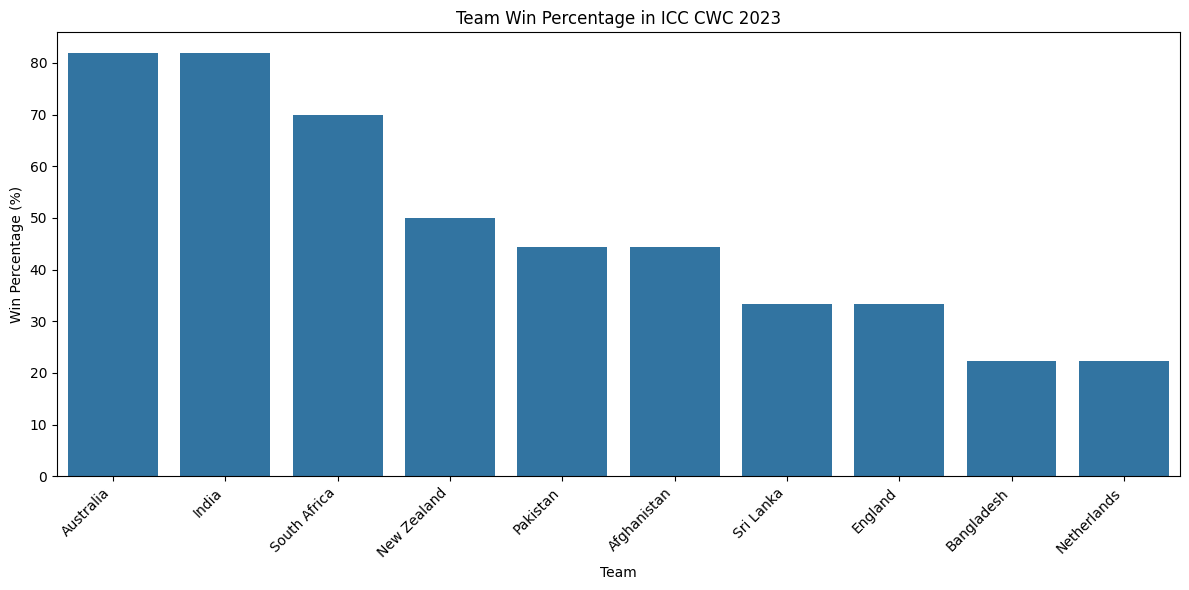

In [ ]:
# Calculate wins for each team
team_wins = matches_df['winner'].value_counts()

# Calculate total matches played by each team using melt operation
team1_matches = matches_df[['team_1']].rename(columns={'team_1': 'team'})
team2_matches = matches_df[['team_2']].rename(columns={'team_2': 'team'})
all_team_matches = pd.concat([team1_matches, team2_matches])
team_matches_played = all_team_matches['team'].value_counts()

# Create win percentage DataFrame directly
win_percentage_df = pd.DataFrame({
    'Team': team_wins.index,
    'Wins': team_wins.values,
    'Matches Played': team_wins.index.map(team_matches_played),
    'Win %': (team_wins / team_wins.index.map(team_matches_played) * 100)
}).sort_values(by='Win %', ascending=False)

print("Team Win Percentage:")
print(win_percentage_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=win_percentage_df, x='Team', y='Win %')
plt.title('Team Win Percentage in ICC CWC 2023')
plt.ylabel('Win Percentage (%)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Batting Strength and Depth

#### Average Runs Per Wicket by Batting Order

In [ ]:
# Data preparation: Create batting order groups
# Ensure batting order is numeric and handle missing values
batting_df['batting_order'] = pd.to_numeric(batting_df['position'], errors='coerce').fillna(99)

def get_batting_group(order):
    """Categorize batting position into groups"""
    if order <= 3:
        return 'Top Order (1-3)'
    elif order <= 7:
        return 'Middle Order (4-7)'
    else:
        return 'Lower Order (8+)'

# Create batting group column
batting_df['batting_group'] = batting_df['batting_order'].apply(get_batting_group)

print("Batting order groups created successfully!")
print("\nBatting group distribution:")
print(batting_df['batting_group'].value_counts())

Batting order groups created successfully!

Batting group distribution:
batting_group
Middle Order (4-7)    361
Top Order (1-3)       300
Lower Order (8+)      255
Name: count, dtype: int64


In [ ]:
# Calculate team totals and wickets per innings
team_innings_summary = batting_df.groupby(['match_id', 'innings', 'team']).agg({
    'runs': 'sum',
    'out_or_not_out': lambda x: (x == 'out').sum()
}).reset_index()

# Rename columns for clarity
team_innings_summary.columns = ['match_id', 'innings', 'team', 'total_runs', 'wickets_lost']

# Calculate runs per wicket (handle division by zero)
team_innings_summary['runs_per_wicket'] = team_innings_summary.apply(
    lambda row: row['total_runs'] / row['wickets_lost'] if row['wickets_lost'] > 0 else row['total_runs'],
    axis=1
)

print(f"Team innings summary created with {len(team_innings_summary)} records")
team_innings_summary.head()

Team innings summary created with 96 records


,match_id,innings,team,total_runs,wickets_lost,runs_per_wicket
0,1,1,England,276,9,30.666667
1,1,2,New Zealand,275,1,275.000000
2,2,1,Pakistan,277,10,27.700000
3,2,2,Netherlands,196,10,19.600000
4,3,1,Bangladesh,150,4,37.500000


Average Runs Per Wicket by Team:
           team  runs_per_wicket
0   New Zealand        68.889740
1         India        65.152273
2      Pakistan        56.056349
3   Afghanistan        51.717593
4     Australia        45.013440
5  South Africa        42.984080
6     Sri Lanka        31.546914
7    Bangladesh        27.102469
8       England        25.288889
9   Netherlands        19.791667


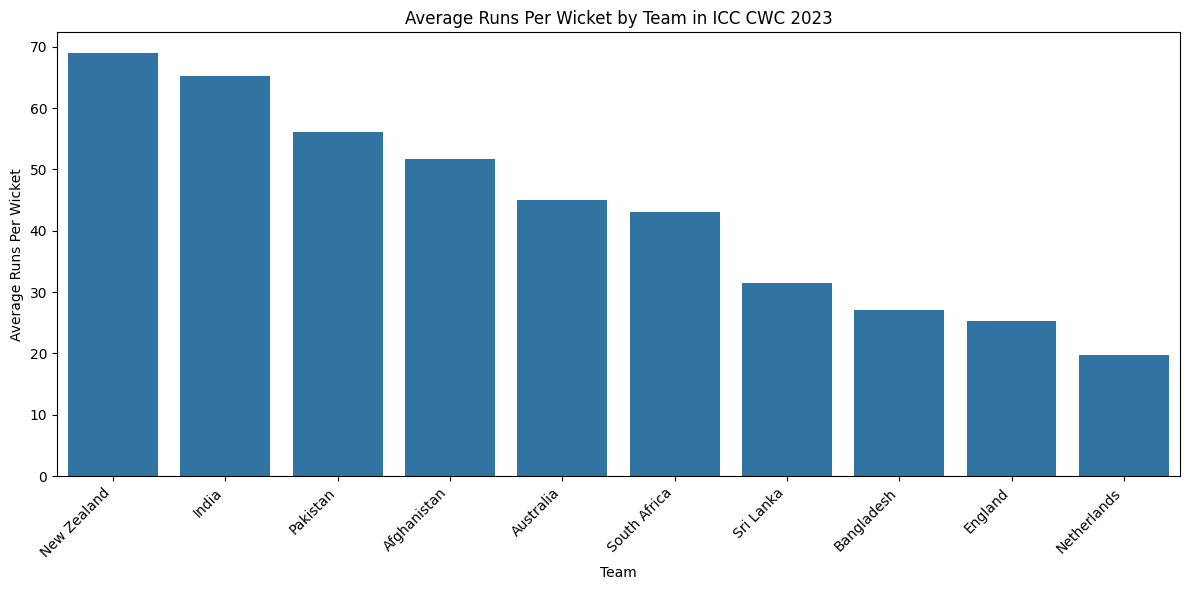

In [ ]:
# Calculate average runs per wicket by team
avg_runs_per_wicket_team = (team_innings_summary
                           .groupby('team')['runs_per_wicket']
                           .mean()
                           .sort_values(ascending=False)
                           .reset_index())

print("Average Runs Per Wicket by Team:")
print(avg_runs_per_wicket_team)

# Visualize team performance
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_runs_per_wicket_team, x='team', y='runs_per_wicket')
plt.title('Average Runs Per Wicket by Team in ICC CWC 2023')
plt.ylabel('Average Runs Per Wicket')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze performance by batting order groups
batting_group_summary = batting_df.groupby(['match_id', 'innings', 'team', 'batting_group']).agg({
    'runs': 'sum',
    'out_or_not_out': lambda x: (x == 'out').sum()
}).reset_index()

# Rename columns
batting_group_summary.columns = ['match_id', 'innings', 'team', 'batting_group', 'total_runs', 'wickets_lost']

# Calculate runs per wicket for each batting group
batting_group_summary['runs_per_wicket'] = batting_group_summary.apply(
    lambda row: row['total_runs'] / row['wickets_lost'] if row['wickets_lost'] > 0 else row['total_runs'],
    axis=1
)

# Average by team and batting group
avg_runs_per_wicket_group = (batting_group_summary
                            .groupby(['team', 'batting_group'])['runs_per_wicket']
                            .mean()
                            .reset_index())

print("Average Runs Per Wicket by Batting Order Group:")
print(avg_runs_per_wicket_group.head(10))

Average Runs Per Wicket by Batting Order Group:
          team       batting_group  runs_per_wicket
0  Afghanistan    Lower Order (8+)        14.633333
1  Afghanistan  Middle Order (4-7)        48.240741
2  Afghanistan     Top Order (1-3)        45.240741
3    Australia    Lower Order (8+)        17.197917
4    Australia  Middle Order (4-7)        40.833333
5    Australia     Top Order (1-3)        48.636364
6   Bangladesh    Lower Order (8+)        16.291667
7   Bangladesh  Middle Order (4-7)        34.250000
8   Bangladesh     Top Order (1-3)        25.851852
9      England    Lower Order (8+)        19.370370


<Figure size 1200x600 with 0 Axes>

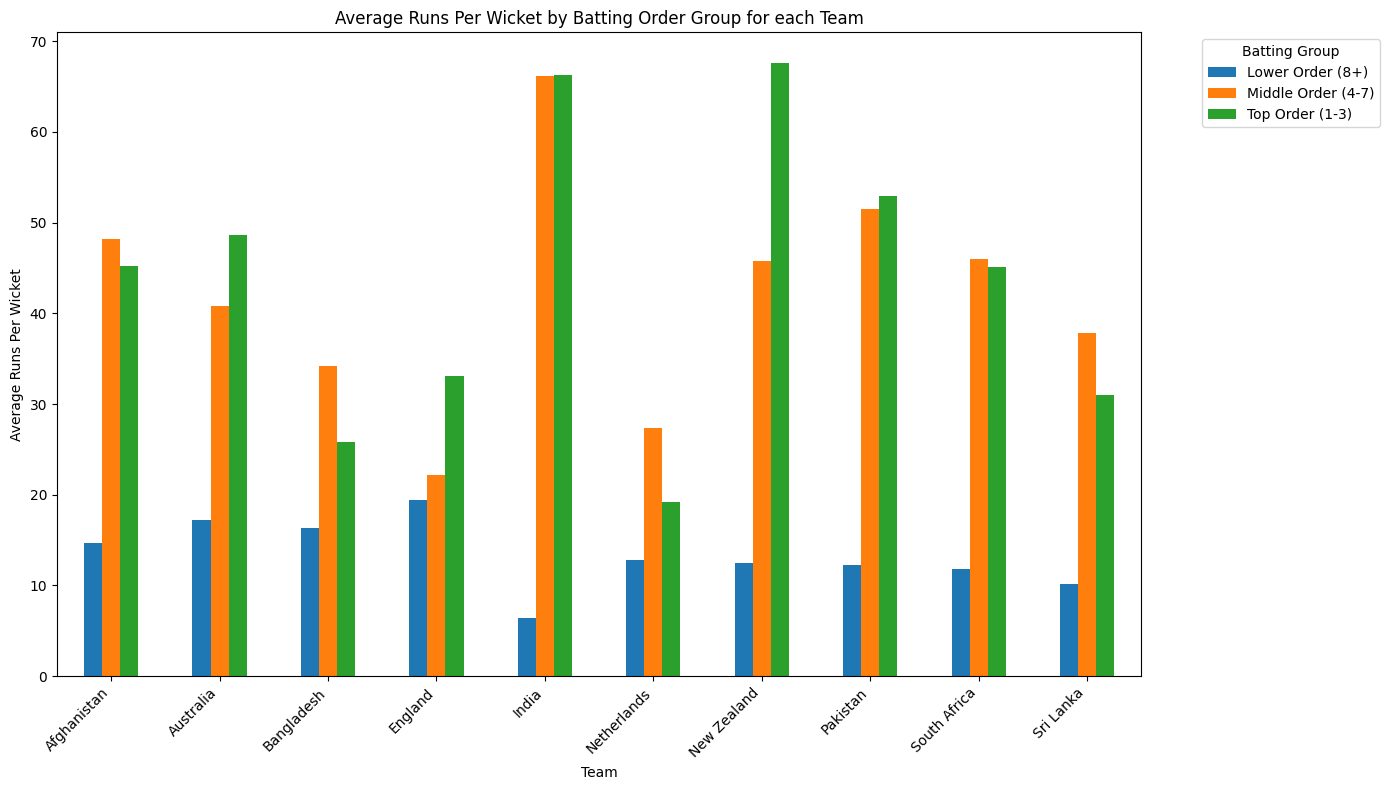

In [ ]:
# Create pivot table for better visualization
avg_runs_per_wicket_pivot = (avg_runs_per_wicket_group
                            .pivot(index='team', columns='batting_group', values='runs_per_wicket')
                            .fillna(0))

# Visualize batting order performance
plt.figure(figsize=(12, 6))
avg_runs_per_wicket_pivot.plot(kind='bar', figsize=(14, 8))
plt.title('Average Runs Per Wicket by Batting Order Group for each Team')
plt.ylabel('Average Runs Per Wicket')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Batting Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Teams with 300+ Scores Analysis

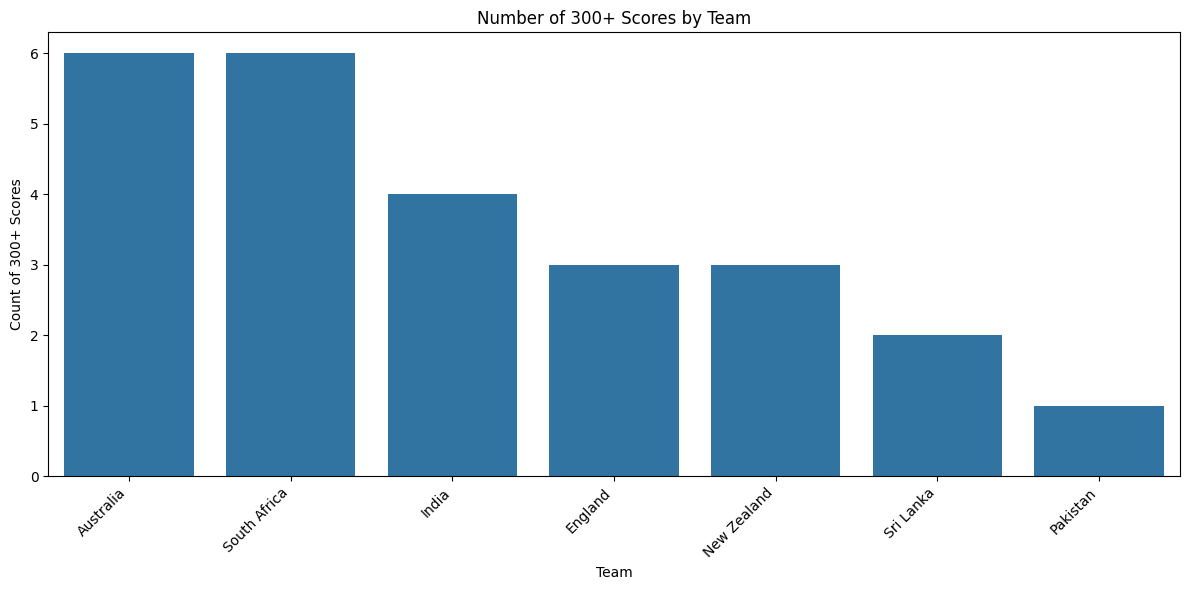

In [ ]:
# Calculate team total scores per innings
team_total_scores = batting_df.groupby(['match_id', 'innings', 'team'])['runs'].sum().reset_index()

# Identify 300+ scores
team_300_plus = team_total_scores[team_total_scores['runs'] >= 300]

total_300_plus_by_team = team_300_plus.groupby('team').agg({
    'runs': ['count', 'mean', 'max']
}).round(2)

# Flatten column names
total_300_plus_by_team.columns = ['Count of 300+ Scores', 'Average Score (300+)', 'Highest Score']
total_300_plus_by_team = total_300_plus_by_team.sort_values('Count of 300+ Scores', ascending=False)

# Visualization - Count of 300+ scores
plt.figure(figsize=(12, 6))
teams = total_300_plus_by_team.index
counts = total_300_plus_by_team['Count of 300+ Scores']

sns.barplot(x=teams, y=counts)
plt.title('Number of 300+ Scores by Team')
plt.ylabel('Count of 300+ Scores')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Most Centuries and Half-Centuries

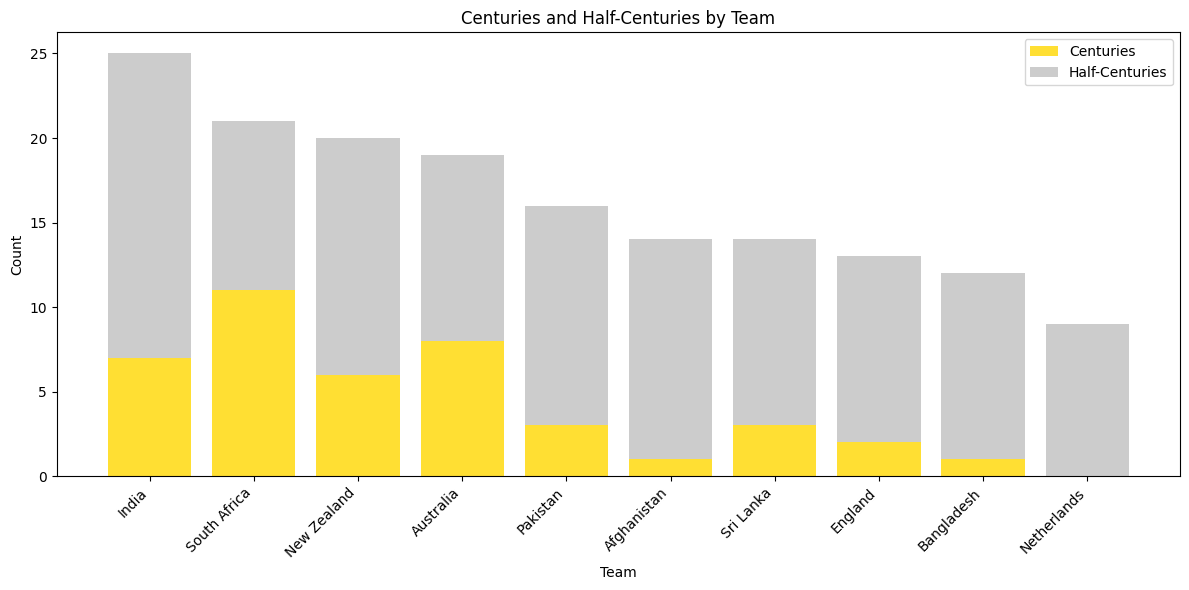

In [ ]:
# Count centuries and half-centuries by team
centuries = batting_df[batting_df['runs'] >= 100].groupby('team').size().sort_values(ascending=False).reset_index(name='Centuries')
half_centuries = batting_df[(batting_df['runs'] >= 50) & (batting_df['runs'] < 100)].groupby('team').size().sort_values(ascending=False).reset_index(name='Half-Centuries')

# Merge the data
centuries_half_centuries = pd.merge(centuries, half_centuries, on='team', how='outer').fillna(0)
centuries_half_centuries['Total 50+ Scores'] = centuries_half_centuries['Centuries'] + centuries_half_centuries['Half-Centuries']
centuries_half_centuries = centuries_half_centuries.sort_values(by='Total 50+ Scores', ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
x_pos = range(len(centuries_half_centuries))
plt.bar(x_pos, centuries_half_centuries['Centuries'], label='Centuries', alpha=0.8, color='gold')
plt.bar(x_pos, centuries_half_centuries['Half-Centuries'], bottom=centuries_half_centuries['Centuries'],
        label='Half-Centuries', alpha=0.8, color='silver')

plt.title('Centuries and Half-Centuries by Team')
plt.ylabel('Count')
plt.xlabel('Team')
plt.xticks(x_pos, centuries_half_centuries['team'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Bowling Strength

#### Total wickets by team

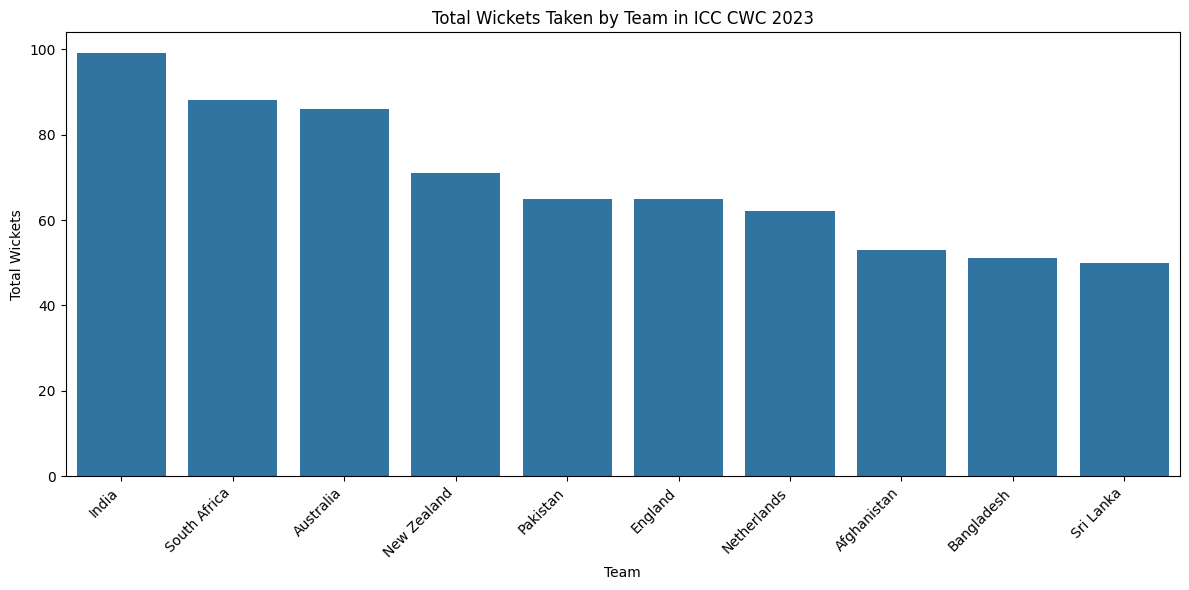

In [ ]:
# Total wickets by team
total_wickets_by_team = bowling_df.groupby('team')['wickets'].sum().sort_values(ascending=False).reset_index()
total_wickets_by_team.rename(columns={'team': 'Team'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=total_wickets_by_team, x='Team', y='wickets')
plt.title('Total Wickets Taken by Team in ICC CWC 2023')
plt.ylabel('Total Wickets')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Teams Bowling Out Opposition Most Frequently

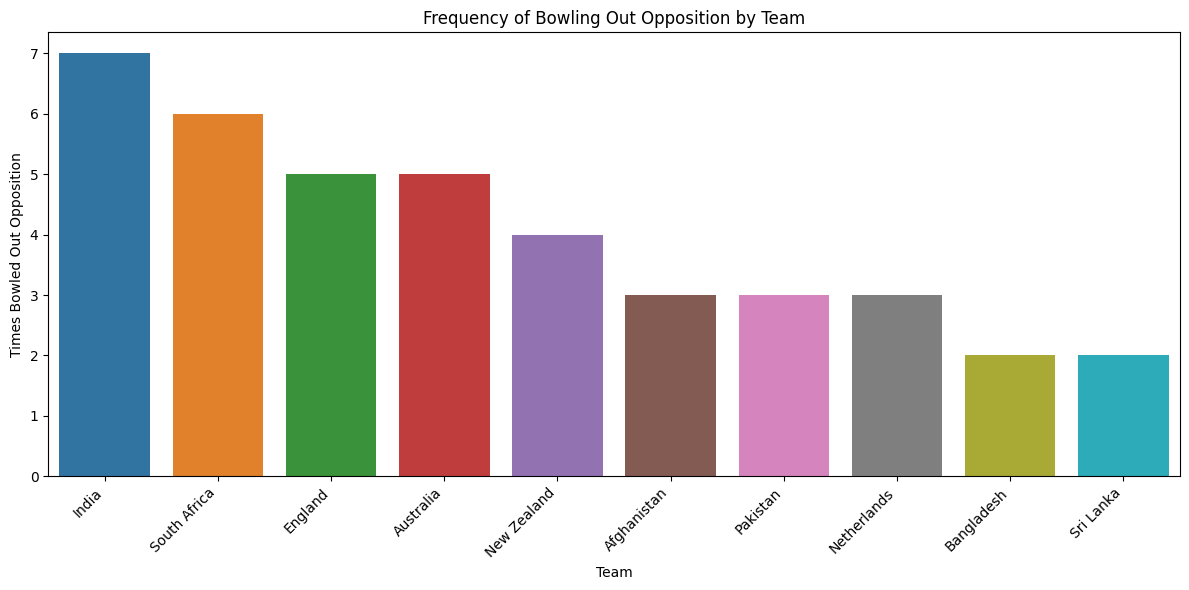

In [ ]:
# Calculate total wickets fallen per innings from batting data
innings_wickets_fallen = batting_df[batting_df['out_or_not_out'] == 'out'].groupby(['match_id', 'innings']).size().reset_index(name='wickets_fallen')

# Merge with match data to identify teams
merged_innings_wickets = pd.merge(innings_wickets_fallen, matches_df[['match_id', 'team_1', 'team_2']], on='match_id')

# Determine batting and bowling teams for each innings
def get_batting_bowling_teams(row):
    if row['innings'] == 1:
        return row['team_1'], row['team_2']  # team_1 bats, team_2 bowls
    else:
        return row['team_2'], row['team_1']  # team_2 bats, team_1 bowls

# Apply the function to get batting and bowling teams
team_assignments = merged_innings_wickets.apply(lambda row: get_batting_bowling_teams(row), axis=1)
merged_innings_wickets['batting_team'] = team_assignments.apply(lambda x: x[0])
merged_innings_wickets['bowling_team'] = team_assignments.apply(lambda x: x[1])

# Filter for innings where 10 wickets fell (team bowled out)
bowled_out_occasions = merged_innings_wickets[merged_innings_wickets['wickets_fallen'] == 10]

bowling_out_frequency = bowled_out_occasions.groupby('bowling_team').size().sort_values(ascending=False).reset_index(name='Times Bowled Out Opposition')
bowling_out_frequency.rename(columns={'bowling_team': 'Team'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=bowling_out_frequency, x='Team', y='Times Bowled Out Opposition', hue='Team', legend=False)
plt.title('Frequency of Bowling Out Opposition by Team')
plt.ylabel('Times Bowled Out Opposition')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Economy Rate Analysis

In [ ]:
# Calculate team bowling statistics
team_bowling_stats = bowling_df.groupby('team').agg(
    total_wickets=('wickets', 'sum'),
    total_runs_conceded=('runs', 'sum'),
    total_overs_bowled=('overs', 'sum'),
    total_maidens=('maidens', 'sum'),
    matches_played=('match_id', 'nunique')
).reset_index()

# Calculate derived statistics
team_bowling_stats['average_bowling_avg'] = team_bowling_stats['total_runs_conceded'] / team_bowling_stats['total_wickets'].replace(0, 1)
team_bowling_stats['average_economy'] = team_bowling_stats['total_runs_conceded'] / team_bowling_stats['total_overs_bowled'].replace(0, 1)
team_bowling_stats['average_strike_rate'] = (team_bowling_stats['total_overs_bowled'] * 6) / team_bowling_stats['total_wickets'].replace(0, 1)

# Rename team column for consistency
team_bowling_stats.rename(columns={'team': 'Team'}, inplace=True)

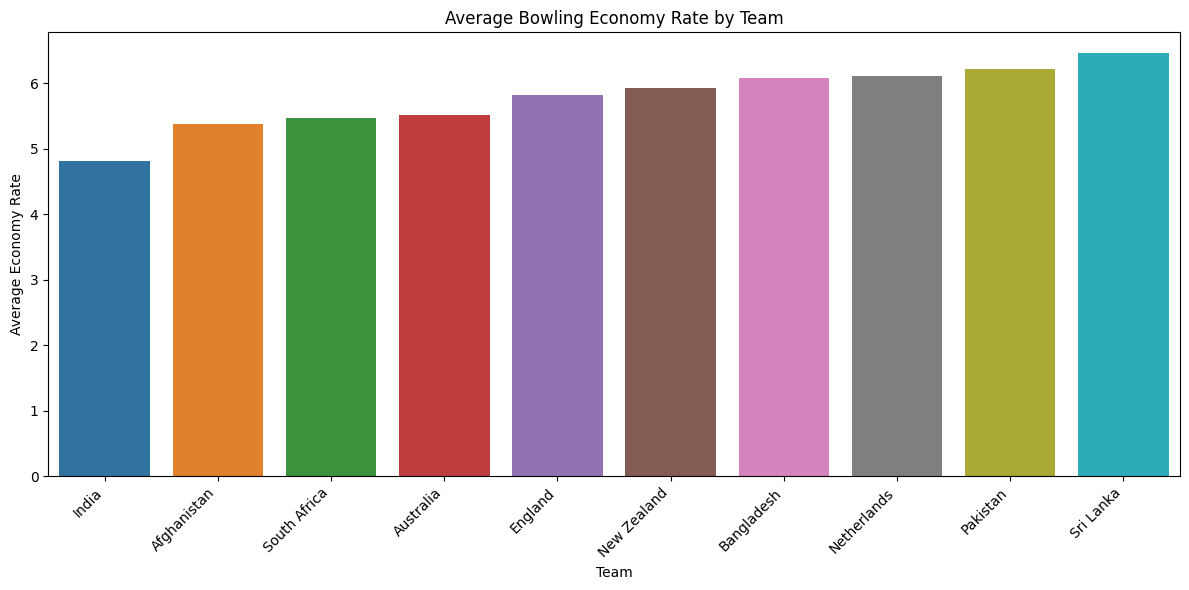

In [ ]:
economy_sorted = team_bowling_stats.sort_values(by='average_economy')

plt.figure(figsize=(12, 6))
sns.barplot(data=economy_sorted, x='Team', y='average_economy', hue='Team', legend=False)
plt.title('Average Bowling Economy Rate by Team')
plt.ylabel('Average Economy Rate')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Bowling Average Analysis

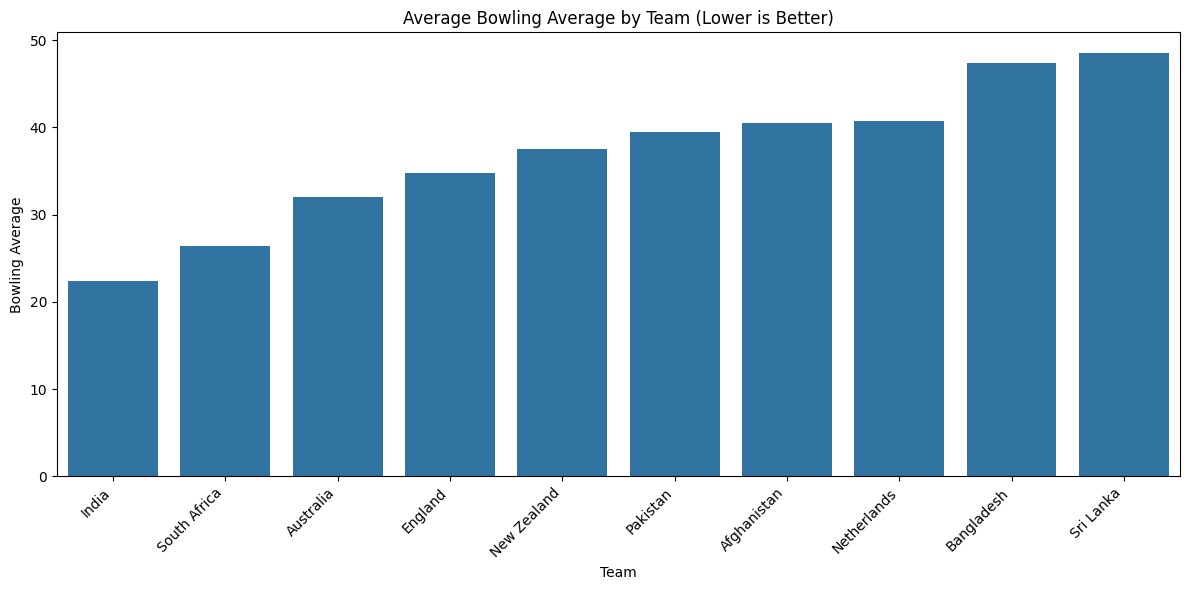

In [ ]:
avg_sorted = team_bowling_stats[team_bowling_stats['total_wickets'] >= 5].sort_values(by='average_bowling_avg')

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sorted, x='Team', y='average_bowling_avg')
plt.title('Average Bowling Average by Team (Lower is Better)')
plt.ylabel('Bowling Average')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Strike Rate Analysis

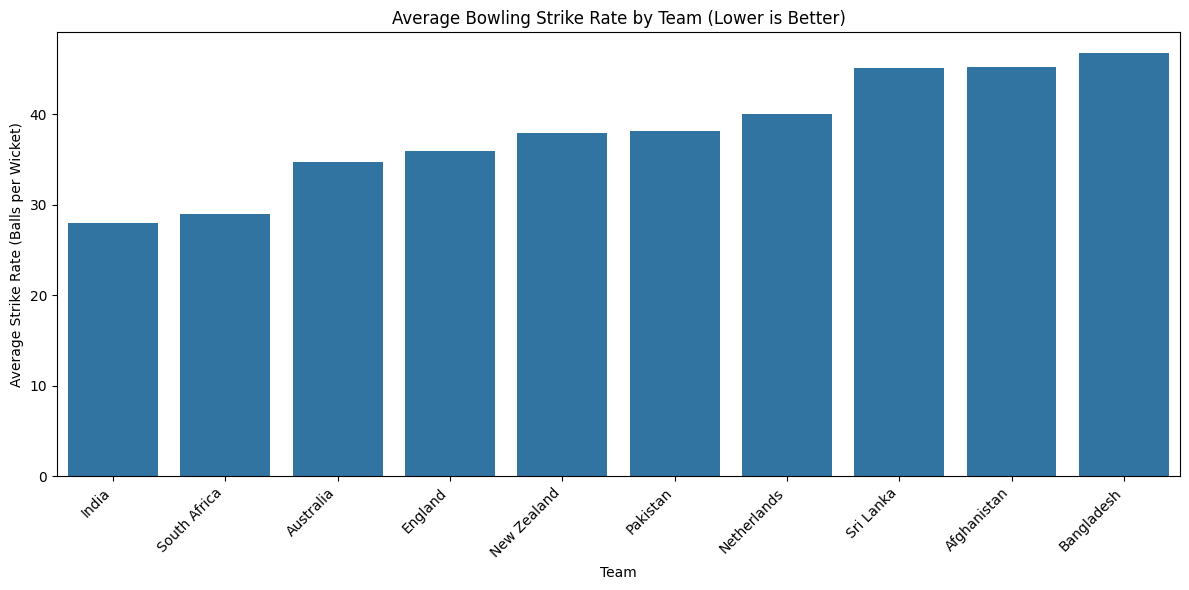

In [ ]:
sr_sorted = team_bowling_stats[team_bowling_stats['total_wickets'] >= 5].sort_values(by='average_strike_rate')

plt.figure(figsize=(12, 6))
sns.barplot(data=sr_sorted, x='Team', y='average_strike_rate')
plt.title('Average Bowling Strike Rate by Team (Lower is Better)')
plt.ylabel('Average Strike Rate (Balls per Wicket)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Pressure Situations

### Teams Record Chasing 300+ or Defending Under 250

In [ ]:
# Calculate team scores per innings for pressure situations analysis

# Get team scores for each innings
team_scores_by_innings = batting_df.groupby(['match_id', 'innings', 'team'])['runs'].sum().reset_index()
team_scores_by_innings = team_scores_by_innings.rename(columns={'runs': 'team_score'})

print("Team scores by innings prepared")
print(f"Total records: {len(team_scores_by_innings)}")
print(team_scores_by_innings.head())

Team scores by innings prepared
Total records: 96
   match_id  innings         team  team_score
0         1        1      England         276
1         1        2  New Zealand         275
2         2        1     Pakistan         277
3         2        2  Netherlands         196
4         3        1   Bangladesh         150


In [ ]:
# Create match summary with first and second innings scores
match_summary = []

for match_id in matches_df['match_id'].unique():
    match_info = matches_df[matches_df['match_id'] == match_id].iloc[0]

    # Get first innings score
    first_innings = team_scores_by_innings[
        (team_scores_by_innings['match_id'] == match_id) &
        (team_scores_by_innings['innings'] == 1)
    ]

    # Get second innings score
    second_innings = team_scores_by_innings[
        (team_scores_by_innings['match_id'] == match_id) &
        (team_scores_by_innings['innings'] == 2)
    ]

    if not first_innings.empty and not second_innings.empty:
        first_team = first_innings.iloc[0]['team']
        first_score = first_innings.iloc[0]['team_score']

        second_team = second_innings.iloc[0]['team']
        second_score = second_innings.iloc[0]['team_score']

        match_summary.append({
            'match_id': match_id,
            'first_innings_team': first_team,
            'first_innings_score': first_score,
            'second_innings_team': second_team,
            'second_innings_score': second_score,
            'winner': match_info['winner']
        })

match_results = pd.DataFrame(match_summary)
print(f"Match results summary created with {len(match_results)} matches")
print(match_results.head())

Match results summary created with 48 matches
   match_id first_innings_team  first_innings_score second_innings_team  \
0         1            England                  276         New Zealand   
1         2           Pakistan                  277         Netherlands   
2         3         Bangladesh                  150         Afghanistan   
3         4       South Africa                  405           Sri Lanka   
4         5              India                  193           Australia   

   second_innings_score        winner  
0                   275   New Zealand  
1                   196      Pakistan  
2                   148    Bangladesh  
3                   306  South Africa  
4                   187         India  


#### Teams chasing 300+ targets

Teams' record when chasing 300+ targets:
  second_innings_team  total_chases  successful_chases  success_rate
4        South Africa             3                  1     33.333333
3            Pakistan             3                  1     33.333333
5           Sri Lanka             3                  1     33.333333
0          Bangladesh             3                  0      0.000000
1         Netherlands             4                  0      0.000000
2         New Zealand             2                  0      0.000000


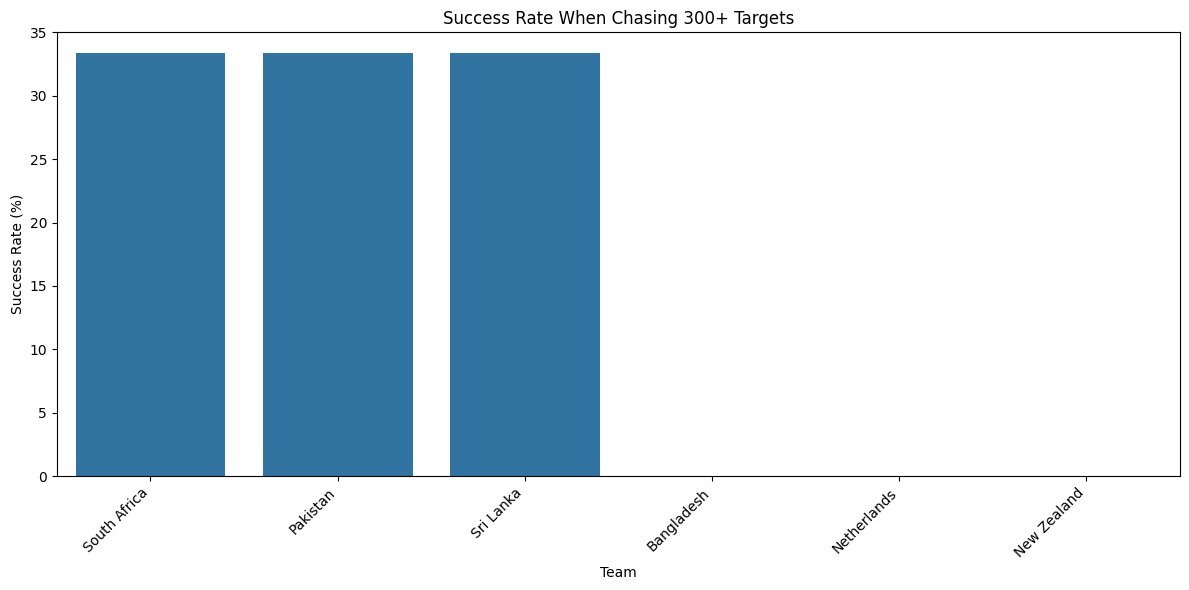

In [ ]:
# Find matches where first innings score was 300+
high_target_matches = match_results[match_results['first_innings_score'] >= 300].copy()

high_target_matches['chase_successful'] = (
    high_target_matches['second_innings_team'] == high_target_matches['winner']
)

# Group by chasing team
chase_300_stats = high_target_matches.groupby('second_innings_team').agg(
    total_chases=('match_id', 'count'),
    successful_chases=('chase_successful', 'sum')
).reset_index()

chase_300_stats['success_rate'] = (chase_300_stats['successful_chases'] / chase_300_stats['total_chases']) * 100
chase_300_stats = chase_300_stats.sort_values('success_rate', ascending=False)

print("Teams' record when chasing 300+ targets:")
print(chase_300_stats)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=chase_300_stats, x='second_innings_team', y='success_rate')
plt.title('Success Rate When Chasing 300+ Targets')
plt.ylabel('Success Rate (%)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Teams defending totals under 250

Teams' record when defending under 250:
  first_innings_team  total_defenses  successful_defenses  success_rate
0        Afghanistan               1                    1    100.000000
1          Australia               1                    1    100.000000
2         Bangladesh               1                    1    100.000000
7           Pakistan               1                    1    100.000000
4              India               4                    3     75.000000
6        New Zealand               3                    2     66.666667
8       South Africa               2                    1     50.000000
5        Netherlands               3                    1     33.333333
3            England               4                    0      0.000000


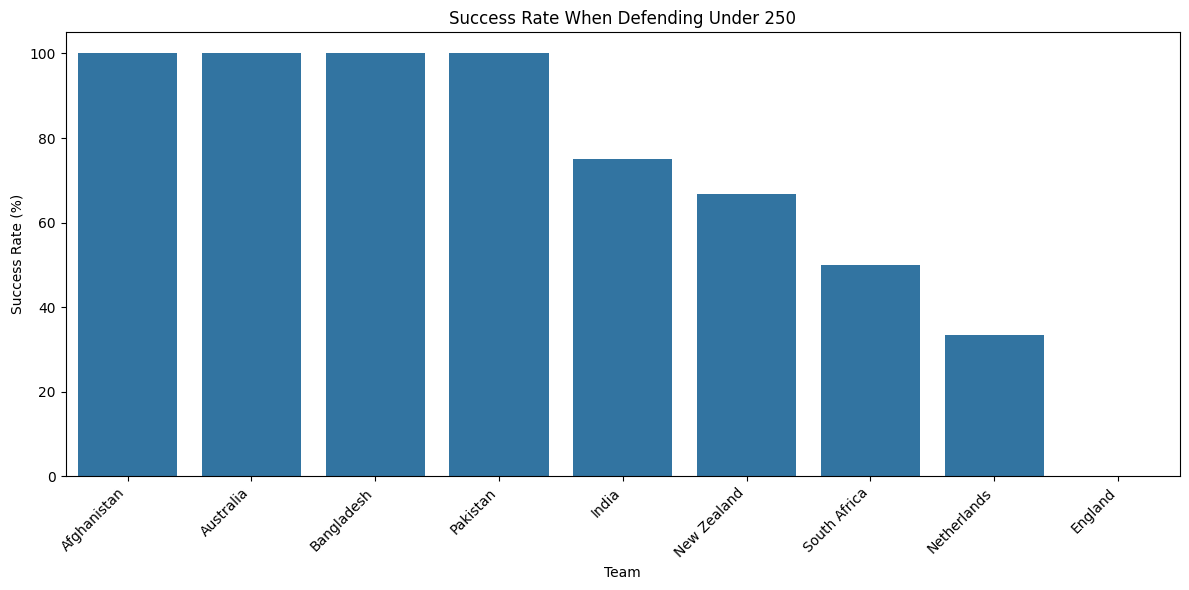

In [ ]:
# Find matches where first innings score was under 250
low_score_matches = match_results[match_results['first_innings_score'] < 250].copy()

low_score_matches['defense_successful'] = (
    low_score_matches['first_innings_team'] == low_score_matches['winner']
)

# Group by defending team
defend_250_stats = low_score_matches.groupby('first_innings_team').agg(
    total_defenses=('match_id', 'count'),
    successful_defenses=('defense_successful', 'sum')
).reset_index()

defend_250_stats['success_rate'] = (defend_250_stats['successful_defenses'] / defend_250_stats['total_defenses']) * 100
defend_250_stats = defend_250_stats.sort_values('success_rate', ascending=False)

print("Teams' record when defending under 250:")
print(defend_250_stats)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=defend_250_stats, x='first_innings_team', y='success_rate')
plt.title('Success Rate When Defending Under 250')
plt.ylabel('Success Rate (%)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Overall chase vs defend statistics

Total matches analyzed: 48
Teams batting first won: 33 matches (68.8%)
Teams batting second won: 15 matches (31.2%)


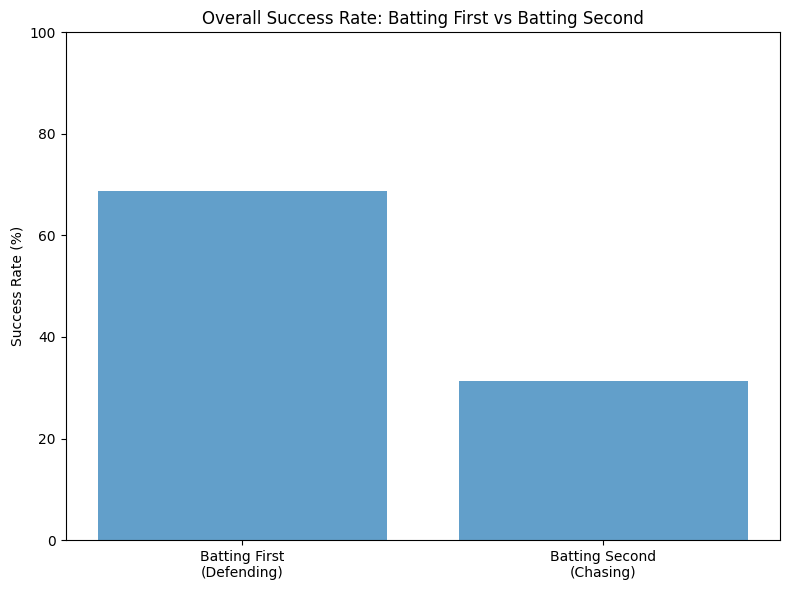

In [ ]:
# Calculate overall success rates
match_results['first_innings_won'] = (match_results['first_innings_team'] == match_results['winner'])
match_results['second_innings_won'] = (match_results['second_innings_team'] == match_results['winner'])

# Overall statistics
total_matches = len(match_results)
first_innings_wins = match_results['first_innings_won'].sum()
second_innings_wins = match_results['second_innings_won'].sum()

defend_success_rate = (first_innings_wins / total_matches) * 100
chase_success_rate = (second_innings_wins / total_matches) * 100

print(f"Total matches analyzed: {total_matches}")
print(f"Teams batting first won: {first_innings_wins} matches ({defend_success_rate:.1f}%)")
print(f"Teams batting second won: {second_innings_wins} matches ({chase_success_rate:.1f}%)")

# Visualization
plt.figure(figsize=(8, 6))
categories = ['Batting First\n(Defending)', 'Batting Second\n(Chasing)']
success_rates = [defend_success_rate, chase_success_rate]

plt.bar(categories, success_rates, alpha=0.7)
plt.title('Overall Success Rate: Batting First vs Batting Second')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Success rates by target ranges

Success rates by target range:
  target_category  total_matches  chase_success_rate  defend_success_rate
4       Under 200              9           55.555556            44.444444
0         200-249             11           36.363636            63.636364
1         250-299             10           30.000000            70.000000
2         300-349              8           12.500000            87.500000
3            350+             10           20.000000            80.000000


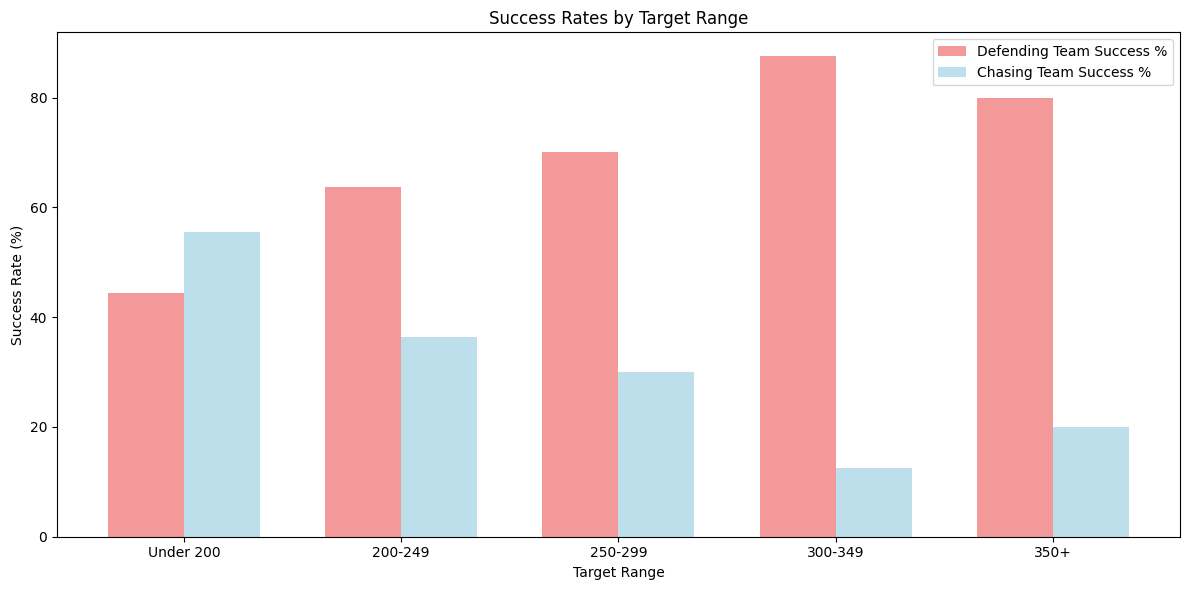

In [ ]:
# Create target range categories
def categorize_target(score):
    if score < 200:
        return "Under 200"
    elif score < 250:
        return "200-249"
    elif score < 300:
        return "250-299"
    elif score < 350:
        return "300-349"
    else:
        return "350+"

match_results['target_category'] = match_results['first_innings_score'].apply(categorize_target)

# Calculate success rates by target range
target_analysis = match_results.groupby('target_category').agg(
    total_matches=('match_id', 'count'),
    chase_wins=('second_innings_won', 'sum'),
    defend_wins=('first_innings_won', 'sum')
).reset_index()

target_analysis['chase_success_rate'] = (target_analysis['chase_wins'] / target_analysis['total_matches']) * 100
target_analysis['defend_success_rate'] = (target_analysis['defend_wins'] / target_analysis['total_matches']) * 100

# Sort by target range
target_order = ["Under 200", "200-249", "250-299", "300-349", "350+"]
target_analysis['target_category'] = pd.Categorical(target_analysis['target_category'], categories=target_order, ordered=True)
target_analysis = target_analysis.sort_values('target_category')

print("Success rates by target range:")
print(target_analysis[['target_category', 'total_matches', 'chase_success_rate', 'defend_success_rate']])

# Visualization
plt.figure(figsize=(12, 6))
x = range(len(target_analysis))
width = 0.35

plt.bar([i - width/2 for i in x], target_analysis['defend_success_rate'],
        width, label='Defending Team Success %', alpha=0.8, color='lightcoral')
plt.bar([i + width/2 for i in x], target_analysis['chase_success_rate'],
        width, label='Chasing Team Success %', alpha=0.8, color='lightblue')

plt.xlabel('Target Range')
plt.ylabel('Success Rate (%)')
plt.title('Success Rates by Target Range')
plt.xticks(x, target_analysis['target_category'])
plt.legend()
plt.tight_layout()
plt.show()

### Players Performance Under Pressure (Scoring 50+ in Chases, Bowling Tight Last Overs)

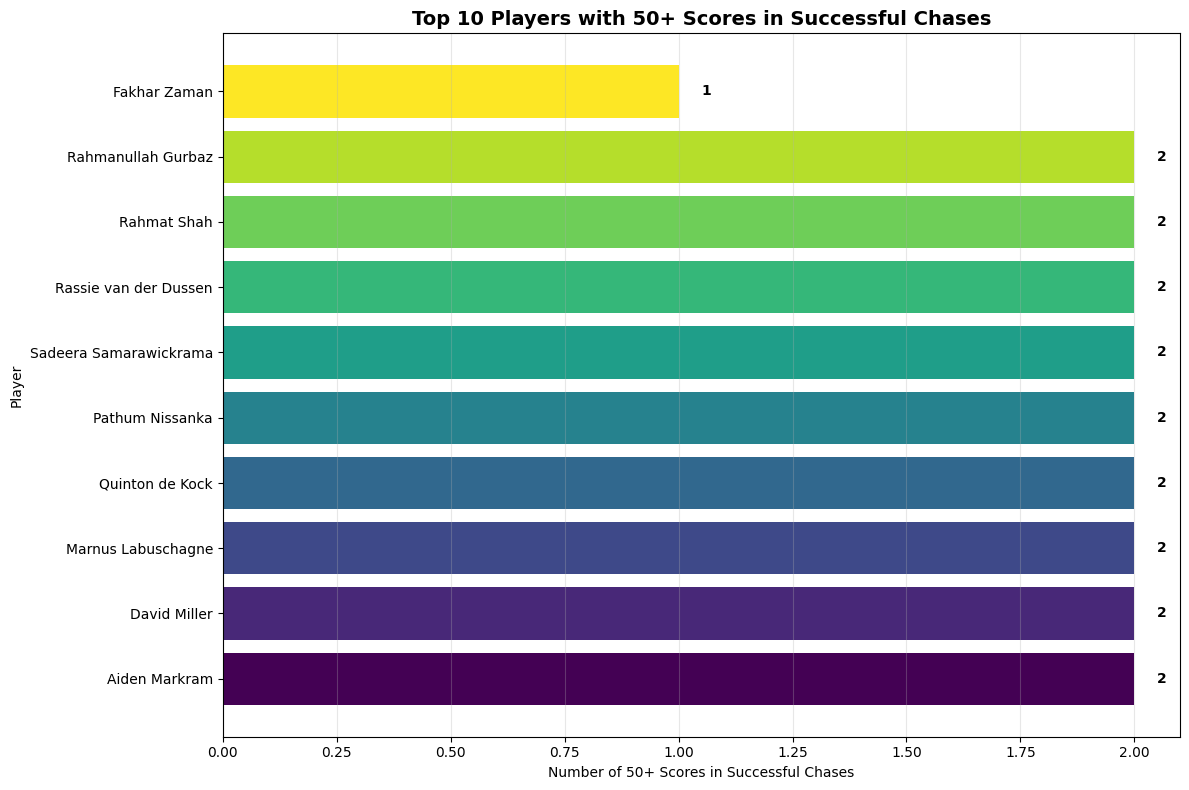

In [ ]:
# Find successful chases (where second innings team won)
successful_chase_matches = match_results[match_results['second_innings_won'] == True]['match_id'].tolist()

# Get batting performances in successful chases (second innings only)
players_in_chases = batting_df[
    (batting_df['match_id'].isin(successful_chase_matches)) &
    (batting_df['innings'] == 2)  # Second innings (chasing)
]

# Filter for players with 50+ runs in successful chases
players_50_plus_in_chases = players_in_chases[players_in_chases['runs'] >= 50]

player_pressure_stats = players_50_plus_in_chases.groupby('batsman').agg(
    fifty_plus_scores=('runs', 'count'),
    total_runs_in_chases=('runs', 'sum'),
    average_score=('runs', 'mean'),
    highest_score=('runs', 'max')
).sort_values(by='fifty_plus_scores', ascending=False).reset_index()

# Visualization - Horizontal bar chart for better readability
top_performers = player_pressure_stats.head(10)
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
bars = plt.barh(range(len(top_performers)), top_performers['fifty_plus_scores'],
                color=plt.cm.viridis(np.linspace(0, 1, len(top_performers))))

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_performers['fifty_plus_scores'])):
    plt.text(value + 0.05, bar.get_y() + bar.get_height()/2,
            f'{int(value)}', va='center', fontweight='bold')

plt.yticks(range(len(top_performers)), top_performers['batsman'])
plt.xlabel('Number of 50+ Scores in Successful Chases')
plt.ylabel('Player')
plt.title('Top 10 Players with 50+ Scores in Successful Chases', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Venue and Toss Impact

### Which Venues Favored Batting First vs Chasing?

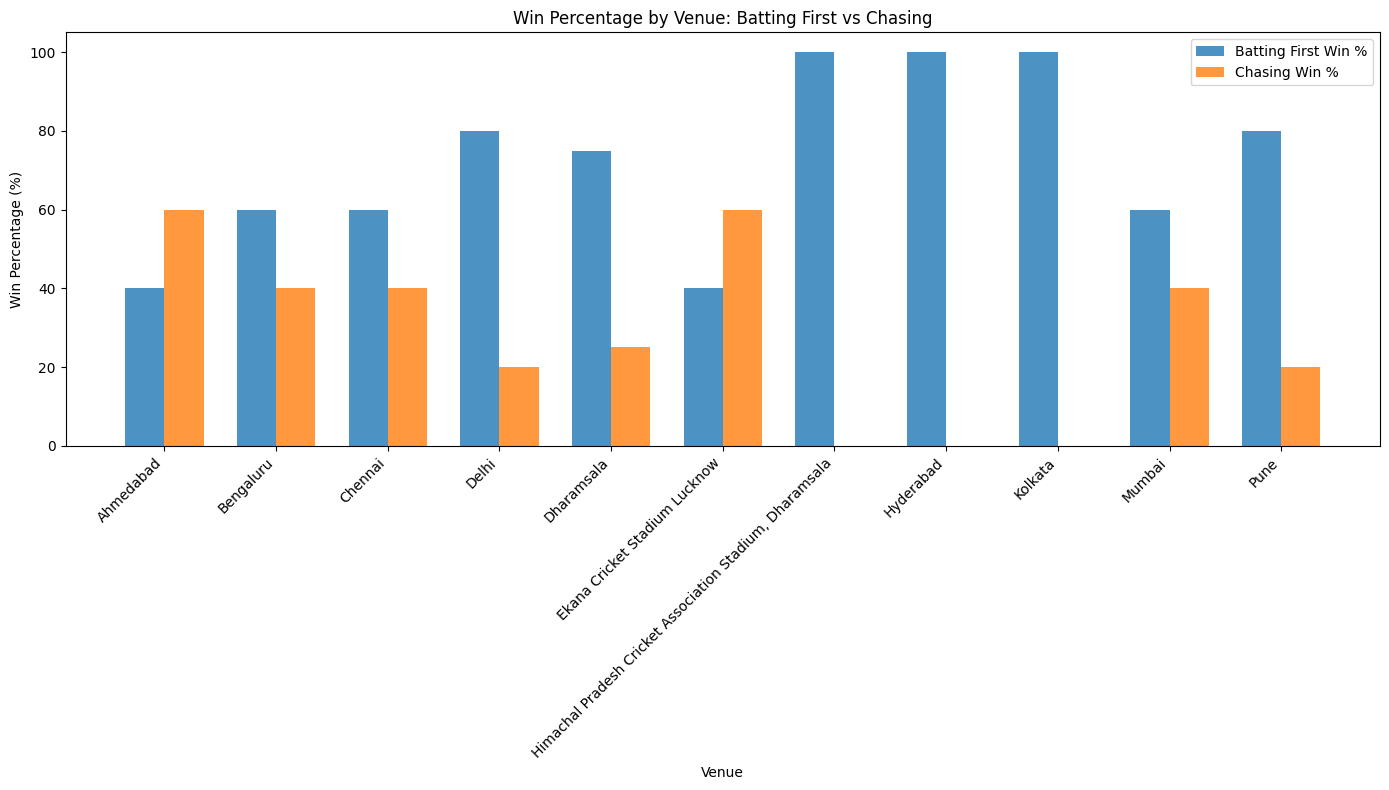

In [ ]:
# Calculate team scores and merge with match data in one step
team_scores_with_venue = (batting_df.groupby(['match_id', 'innings', 'team'])['runs']
                         .sum()
                         .reset_index()
                         .merge(matches_df[['match_id', 'venue', 'winner']], on='match_id'))

# Add match outcome columns
team_scores_with_venue['batted_first'] = team_scores_with_venue['innings'] == 1
team_scores_with_venue['won_match'] = team_scores_with_venue['team'] == team_scores_with_venue['winner']

# Calculate win percentages by venue and batting order
venue_wins = (team_scores_with_venue.groupby(['venue', 'batted_first'])
             .agg(total_innings=('match_id', 'count'),
                  wins=('won_match', 'sum'))
             .reset_index())

venue_wins['win_percentage'] = (venue_wins['wins'] / venue_wins['total_innings']) * 100

# Create pivot table for visualization
venue_pivot = (venue_wins.pivot(index='venue', columns='batted_first', values='win_percentage')
               .fillna(0))
venue_pivot.columns = ['Chasing Win %', 'Batting First Win %']

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
x = range(len(venue_pivot))
width = 0.35

ax.bar([i - width/2 for i in x], venue_pivot['Batting First Win %'],
       width, label='Batting First Win %', alpha=0.8)
ax.bar([i + width/2 for i in x], venue_pivot['Chasing Win %'],
       width, label='Chasing Win %', alpha=0.8)

ax.set_xlabel('Venue')
ax.set_ylabel('Win Percentage (%)')
ax.set_title('Win Percentage by Venue: Batting First vs Chasing')
ax.set_xticks(x)
ax.set_xticklabels(venue_pivot.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


### How Did Average First Innings Scores Vary by Venue?

In [ ]:
# Calculate average first innings scores by venue
first_innings_scores = team_scores_with_venue[team_scores_with_venue['innings'] == 1]
venue_scores = first_innings_scores.groupby('venue')['runs'].agg(['mean', 'count']).round(2)
venue_scores.columns = ['Average Score', 'Number of Matches']
venue_scores = venue_scores.sort_values('Average Score', ascending=False)

print("Average First Innings Scores by Venue:")
print(venue_scores)

Average First Innings Scores by Venue:
                                                    Average Score  \
venue                                                               
Mumbai                                                     306.20   
Delhi                                                      302.20   
Hyderabad                                                  301.67   
Bengaluru                                                  286.20   
Kolkata                                                    278.80   
Dharamsala                                                 271.25   
Himachal Pradesh Cricket Association Stadium, D...         269.00   
Pune                                                       253.00   
Chennai                                                    244.80   
Ekana Cricket Stadium Lucknow                              236.80   
Ahmedabad                                                  234.20   

                                                    Number of M

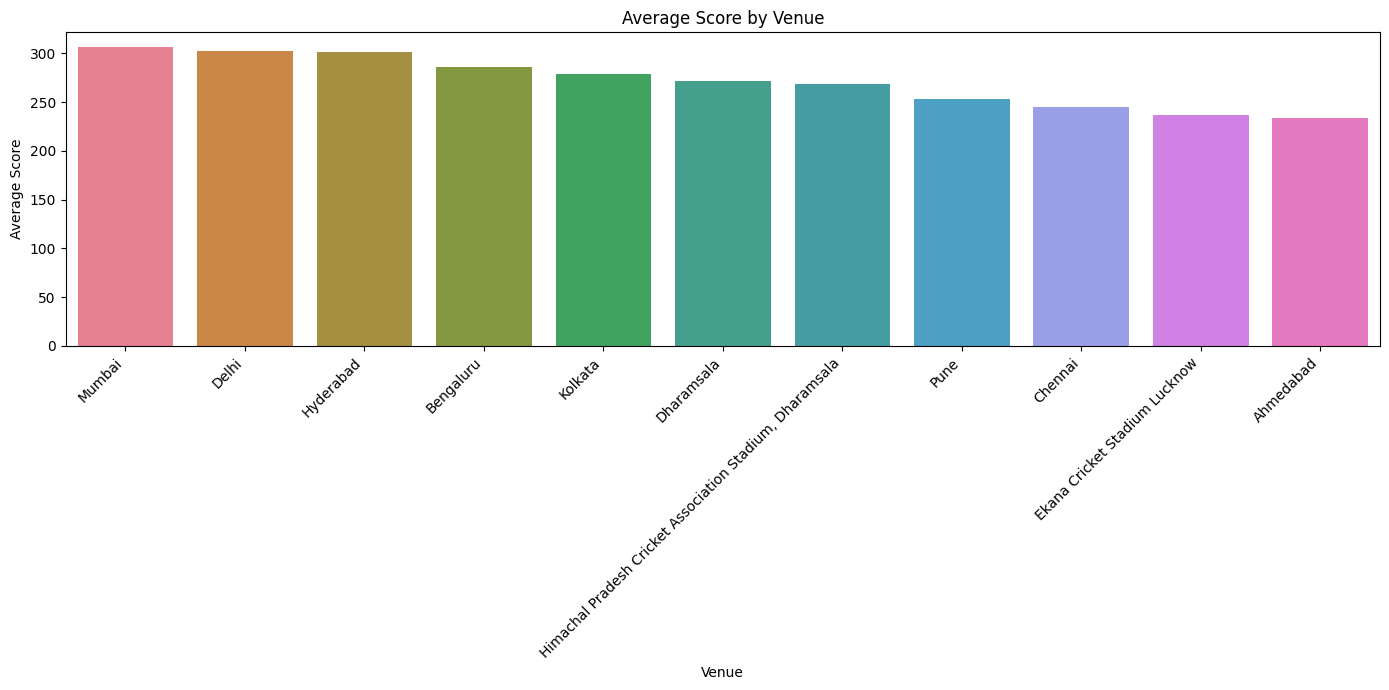

In [ ]:
# Create a simple visualization of average scores by venue (fixed seaborn warning)
plt.figure(figsize=(14, 7))
venues = venue_scores.index
avg_scores = venue_scores['Average Score']

sns.barplot(x=venues, y=avg_scores, hue=venues, legend=False)
plt.title('Average Score by Venue')
plt.ylabel('Average Score')
plt.xlabel('Venue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 8. Top 10 Players (Batsmen and Bowlers)

#### Top 10 Run Scorers

In [ ]:
# Calculate comprehensive batsman statistics
batsman_stats = batting_df.groupby('batsman').agg(
    total_runs=('runs', 'sum'),
    matches_played=('match_id', 'nunique'),
    innings_played=('runs', 'count'),
    times_out=('out_or_not_out', lambda x: (x == 'out').sum()),
    times_not_out=('out_or_not_out', lambda x: (x == 'not out').sum()),
    highest_score=('runs', 'max'),
    total_balls=('balls', 'sum'),
    total_fours=('fours', 'sum'),
    total_sixes=('sixes', 'sum')
).reset_index()

# Rename the batsman column for consistency
batsman_stats.rename(columns={'batsman': 'Batsman_Name'}, inplace=True)

# Calculate derived statistics
batsman_stats['average'] = batsman_stats['total_runs'] / batsman_stats['times_out'].replace(0, 1)
batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['total_balls'].replace(0, 1)) * 100

# Count centuries and half-centuries
batsman_stats['hundreds'] = batting_df.groupby('batsman')['runs'].apply(lambda x: (x >= 100).sum()).values
batsman_stats['fifties'] = batting_df.groupby('batsman')['runs'].apply(lambda x: ((x >= 50) & (x < 100)).sum()).values

# Fill NaN values with 0 for cleaner output
batsman_stats = batsman_stats.fillna(0)

print("Batsman statistics calculated successfully!")
print(f"Total batsmen: {len(batsman_stats)}")
print(batsman_stats.head())

Batsman statistics calculated successfully!
Total batsmen: 146
        Batsman_Name  total_runs  matches_played  innings_played  times_out  \
0  Abdullah Shafique         336               8               8          8   
1         Adam Zampa          59               7               7          4   
2        Adil Rashid          92               9               9          6   
3        Agha Salman          51               1               1          1   
4      Aiden Markram         472              10              12         12   

   times_not_out  highest_score  total_balls  total_fours  total_sixes  \
0              0            113          360           36            9   
1              3             29           76            6            0   
2              3             20           91            7            2   
3              0             51           45            6            1   
4              0            106          430           53           10   

     average  str

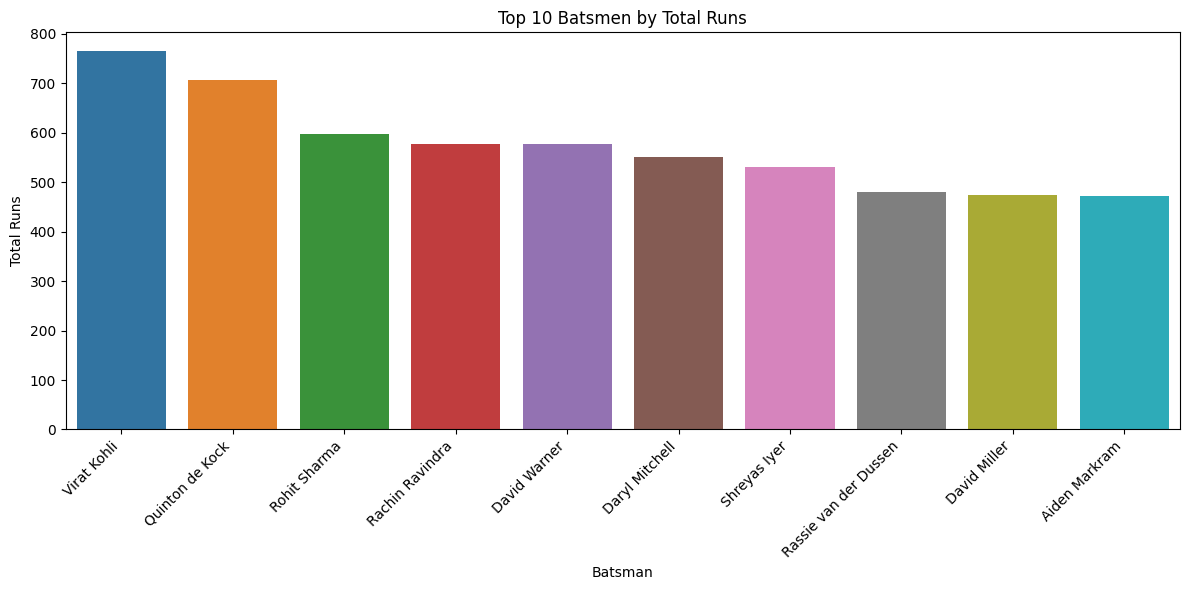

In [ ]:
# Top 10 by total runs
top_runs = batsman_stats.nlargest(10, 'total_runs')[['Batsman_Name', 'total_runs', 'average', 'strike_rate', 'hundreds', 'fifties']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_runs, x='Batsman_Name', y='total_runs', hue='Batsman_Name', legend=False)
plt.title('Top 10 Batsmen by Total Runs')
plt.ylabel('Total Runs')
plt.xlabel('Batsman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Highest Batting Averages

Top 10 Batsmen by Average (Min 200 runs):
           Batsman_Name  total_runs  average  strike_rate  times_out
143         Virat Kohli         765    95.62        90.32          8
58      Kane Williamson         256    85.33        93.43          3
56             KL Rahul         452    75.33        90.76          6
31         Fakhar Zaman         220    73.33       122.91          3
9    Azmatullah Omarzai         353    70.60        97.78          5
18       Daryl Mitchell         552    69.00       111.07          8
125        Shreyas Iyer         530    66.25       113.25          8
88      Mohammad Rizwan         395    65.83        95.41          6
104     Rachin Ravindra         578    64.22       106.45          9
103     Quinton de Kock         706    58.83       104.59         12


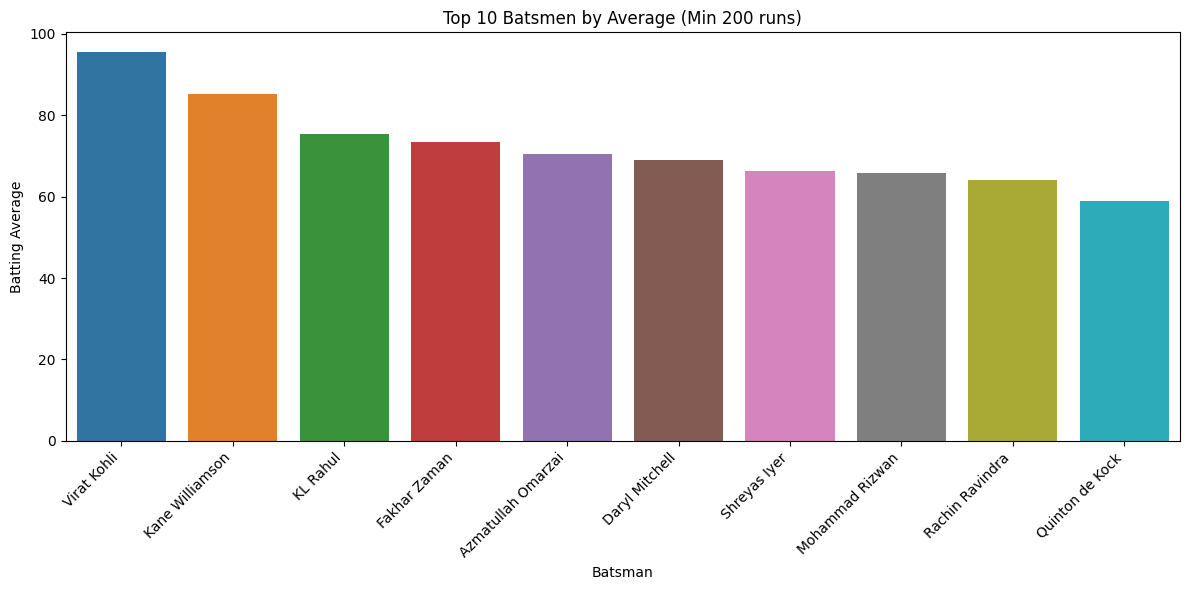

In [ ]:
# Top 10 by batting average (minimum 200 runs)
top_avg = batsman_stats[batsman_stats['total_runs'] >= 200].nlargest(10, 'average')[['Batsman_Name', 'total_runs', 'average', 'strike_rate', 'times_out']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_avg, x='Batsman_Name', y='average', hue='Batsman_Name', legend=False)
plt.title('Top 10 Batsmen by Average (Min 200 runs)')
plt.ylabel('Batting Average')
plt.xlabel('Batsman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Highest Strike Rates

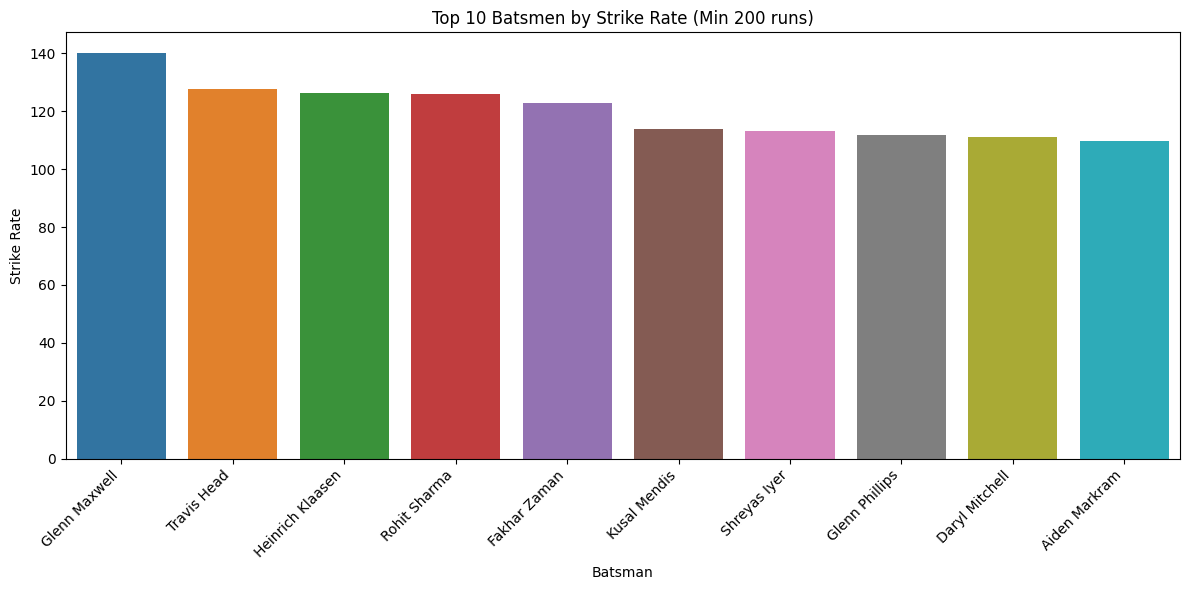

In [ ]:
# Top 10 by strike rate (minimum 200 runs)
top_sr = batsman_stats[batsman_stats['total_runs'] >= 200].nlargest(10, 'strike_rate')[['Batsman_Name', 'total_runs', 'average', 'strike_rate', 'total_fours', 'total_sixes']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sr, x='Batsman_Name', y='strike_rate', hue='Batsman_Name', legend=False)
plt.title('Top 10 Batsmen by Strike Rate (Min 200 runs)')
plt.ylabel('Strike Rate')
plt.xlabel('Batsman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Most Centuries and Half-Centuries

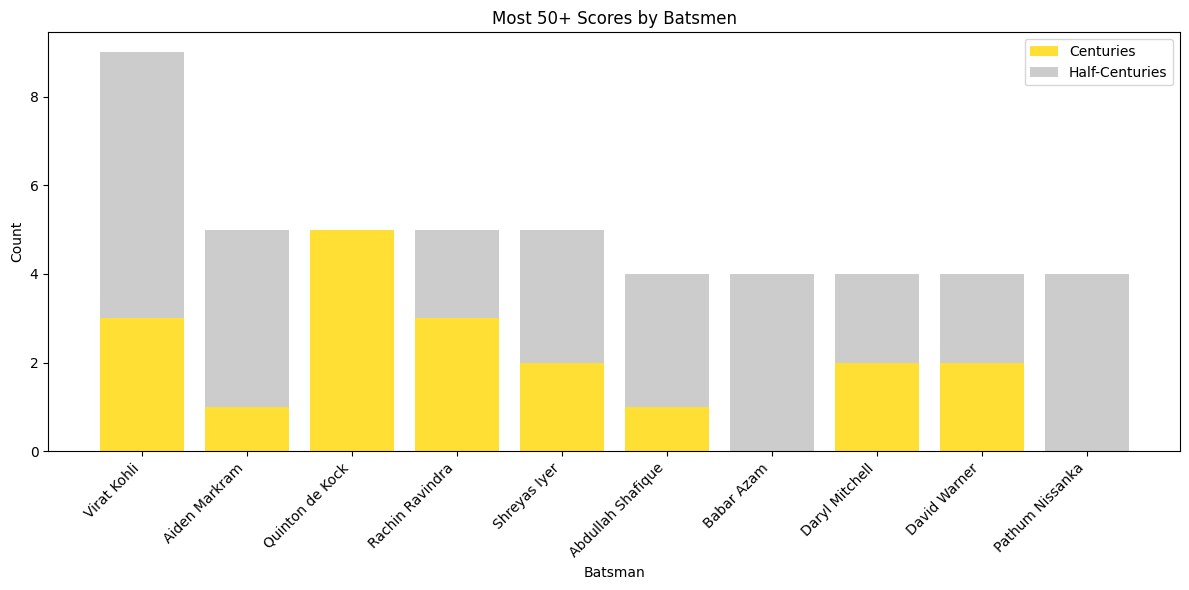

In [ ]:
# Players with most half-centuries
most_fifties = batsman_stats.nlargest(10, 'fifties')[['Batsman_Name', 'fifties', 'hundreds', 'total_runs', 'average']]

# Visualization for 50+ scores
batsman_stats['total_50_plus'] = batsman_stats['hundreds'] + batsman_stats['fifties']
top_50_plus = batsman_stats.nlargest(10, 'total_50_plus')

plt.figure(figsize=(12, 6))
x_pos = range(len(top_50_plus))
plt.bar(x_pos, top_50_plus['hundreds'], label='Centuries', alpha=0.8, color='gold')
plt.bar(x_pos, top_50_plus['fifties'], bottom=top_50_plus['hundreds'],
        label='Half-Centuries', alpha=0.8, color='silver')

plt.title('Most 50+ Scores by Batsmen')
plt.ylabel('Count')
plt.xlabel('Batsman')
plt.xticks(x_pos, top_50_plus['Batsman_Name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Top 10 Bowlers

#### Top 10 Wicket Takers

In [ ]:
# Calculate comprehensive bowler statistics
bowler_stats = bowling_df.groupby('bowler').agg(
    total_wickets=('wickets', 'sum'),
    total_runs_conceded=('runs', 'sum'),
    total_overs=('overs', 'sum'),
    total_maidens=('maidens', 'sum'),
    matches_played=('match_id', 'nunique'),
    innings_bowled=('wickets', 'count')
).reset_index()

# Rename the bowler column for consistency
bowler_stats.rename(columns={'bowler': 'Bowler_Name'}, inplace=True)

# Calculate derived statistics
bowler_stats['bowling_average'] = bowler_stats['total_runs_conceded'] / bowler_stats['total_wickets'].replace(0, 1)
bowler_stats['economy_rate'] = bowler_stats['total_runs_conceded'] / bowler_stats['total_overs'].replace(0, 1)
bowler_stats['strike_rate'] = (bowler_stats['total_overs'] * 6) / bowler_stats['total_wickets'].replace(0, 1)

# Calculate best bowling figures
bowler_best_figures = bowling_df.loc[bowling_df.groupby('bowler')['wickets'].idxmax()][['bowler', 'wickets', 'runs']]
bowler_best_figures.rename(columns={'bowler': 'Bowler_Name', 'wickets': 'best_figures_wickets', 'runs': 'best_figures_runs'}, inplace=True)

# Merge best figures with main stats
bowler_stats = pd.merge(bowler_stats, bowler_best_figures, on='Bowler_Name', how='left')

# Fill NaN values with 0 for cleaner output
bowler_stats = bowler_stats.fillna(0)

print("Bowler statistics calculated successfully!")
print(f"Total bowlers: {len(bowler_stats)}")
print(bowler_stats.head())

Bowler statistics calculated successfully!
Total bowlers: 102
          Bowler_Name  total_wickets  total_runs_conceded  total_overs  \
0          Adam Zampa             23                  515         96.0   
1         Adil Rashid             15                  413         79.4   
2         Agha Salman              0                   46          5.0   
3       Aiden Markram              1                   85         18.3   
4  Andile Phehlukwayo              1                   36          7.0   

   total_maidens  matches_played  innings_bowled  bowling_average  \
0              1              11              11        22.391304   
1              1               9               9        27.533333   
2              0               2               2        46.000000   
3              1               4               4        85.000000   
4              0               1               1        36.000000   

   economy_rate  strike_rate  best_figures_wickets  best_figures_runs  
0     

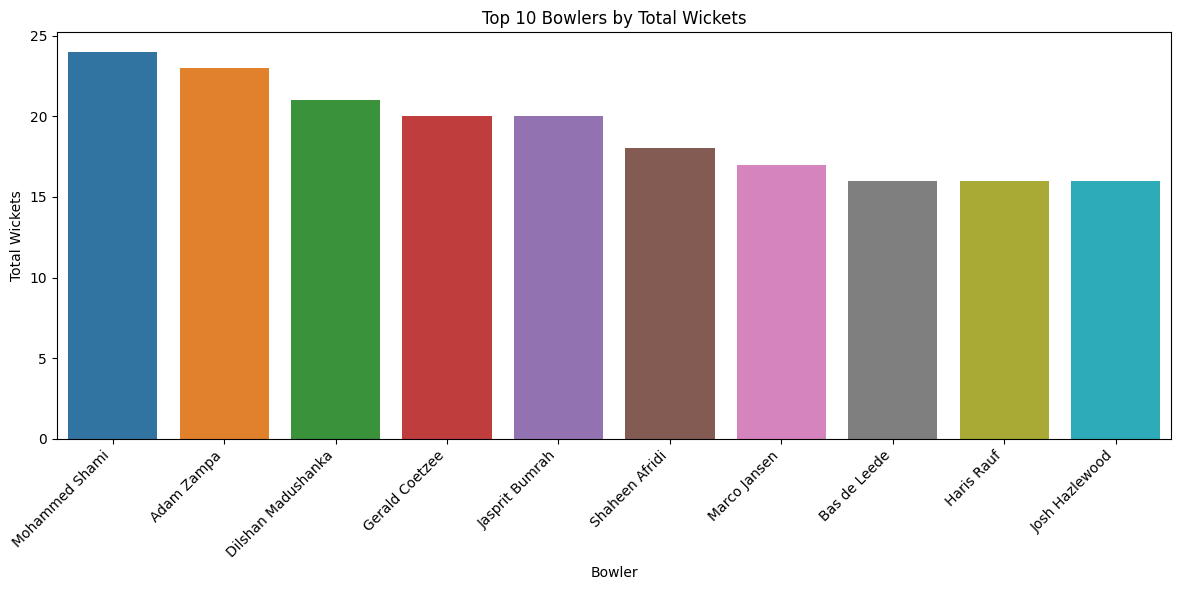

In [ ]:
# Top 10 by total wickets
top_wickets = bowler_stats.nlargest(10, 'total_wickets')[['Bowler_Name', 'total_wickets', 'bowling_average', 'economy_rate', 'strike_rate', 'best_figures_wickets']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_wickets, x='Bowler_Name', y='total_wickets', hue='Bowler_Name', legend=False)
plt.title('Top 10 Bowlers by Total Wickets')
plt.ylabel('Total Wickets')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Best Bowling Averages

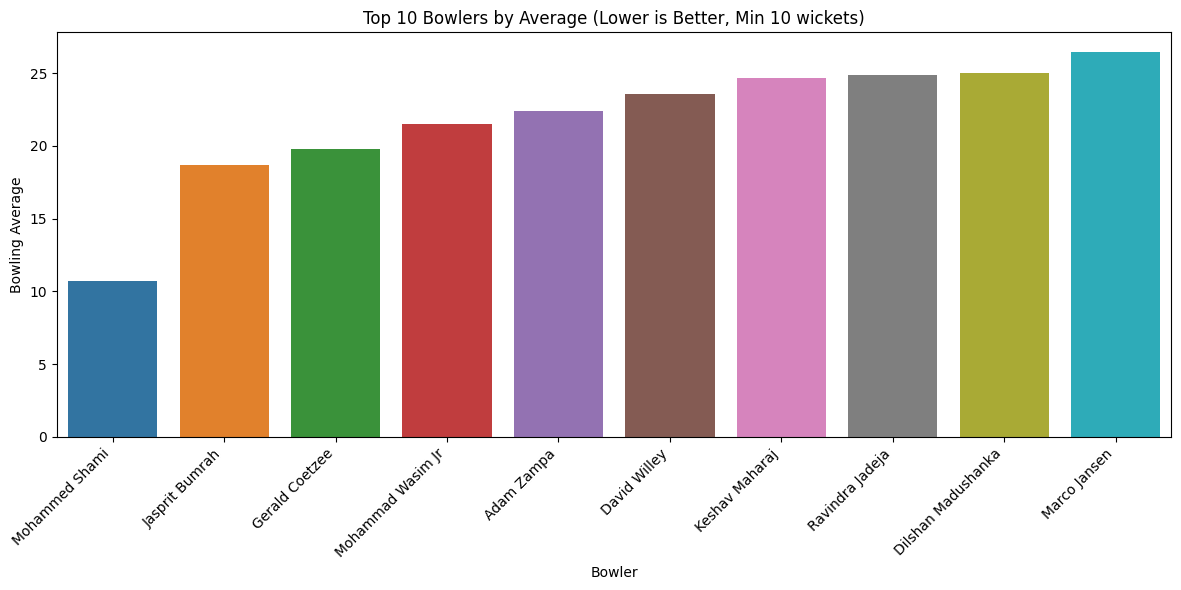

In [ ]:
# Top 10 by bowling average (minimum 10 wickets)
best_avg = bowler_stats[bowler_stats['total_wickets'] >= 10].nsmallest(10, 'bowling_average')[['Bowler_Name', 'total_wickets', 'bowling_average', 'economy_rate', 'strike_rate']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=best_avg, x='Bowler_Name', y='bowling_average', hue='Bowler_Name', legend=False)
plt.title('Top 10 Bowlers by Average (Lower is Better, Min 10 wickets)')
plt.ylabel('Bowling Average')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Best Economy Rates

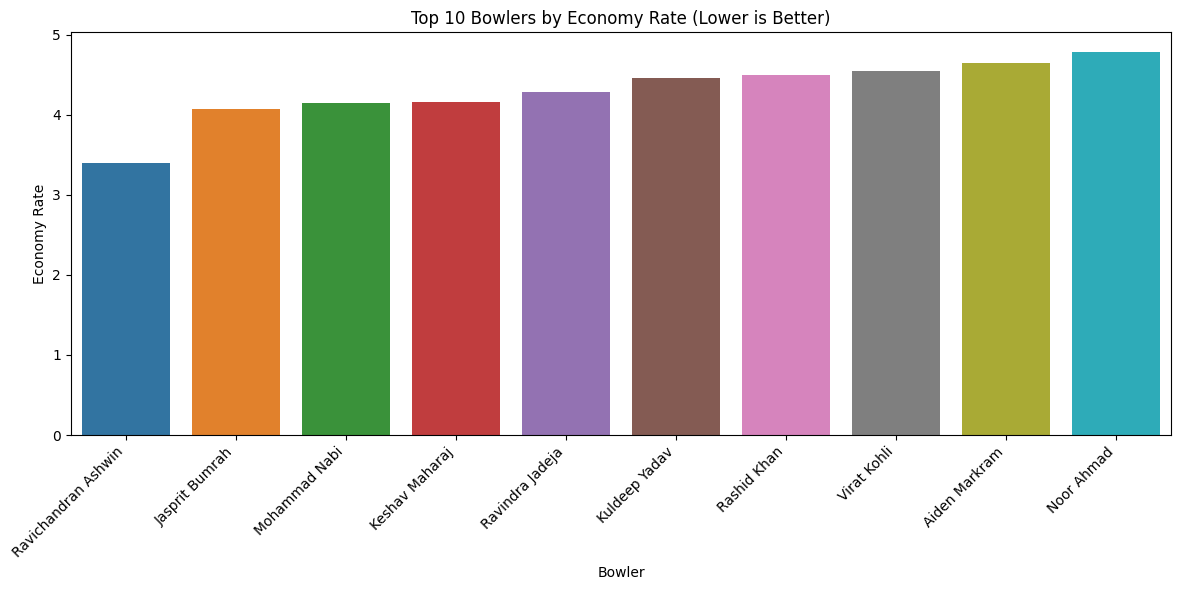

In [ ]:
# Top 10 by economy rate
best_economy = bowler_stats.nsmallest(10, 'economy_rate')[['Bowler_Name', 'total_wickets', 'bowling_average', 'economy_rate', 'total_maidens']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=best_economy, x='Bowler_Name', y='economy_rate', hue='Bowler_Name', legend=False)
plt.title('Top 10 Bowlers by Economy Rate (Lower is Better)')
plt.ylabel('Economy Rate')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Best Strike Rates

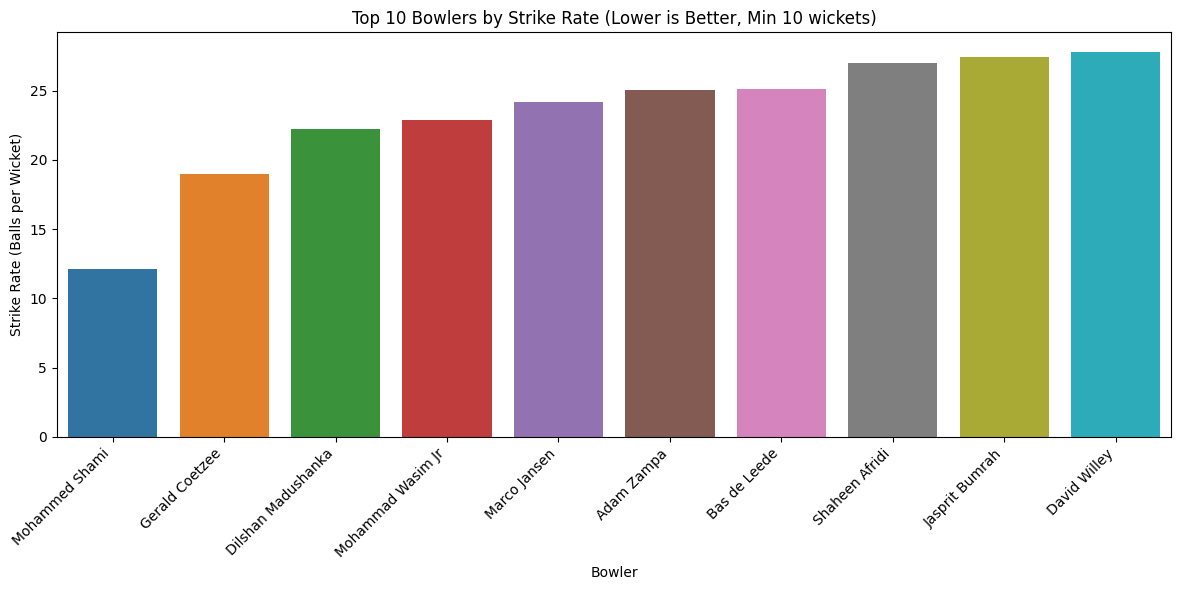

In [ ]:
# Top 10 by strike rate (minimum 10 wickets)
best_sr = bowler_stats[bowler_stats['total_wickets'] >= 10].nsmallest(10, 'strike_rate')[['Bowler_Name', 'total_wickets', 'bowling_average', 'economy_rate', 'strike_rate']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=best_sr, x='Bowler_Name', y='strike_rate', hue='Bowler_Name', legend=False)
plt.title('Top 10 Bowlers by Strike Rate (Lower is Better, Min 10 wickets)')
plt.ylabel('Strike Rate (Balls per Wicket)')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()